In [1]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib_inline
from pathlib import Path
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from catboost import CatBoostRegressor
import shap
shap.initjs()

In [2]:
%load_ext autoreload
%autoreload 1
%aimport src.models.features
from src.models.features import FEATURES

In [3]:
DATA_PATH = Path('../../data')
df = pd.read_parquet(DATA_PATH.joinpath('processed', 'train.parquet'))

In [4]:
df = df[[
    'Attendance',
    'Date',
    'Gm#',
    'R',
    'RA',
    'Rank',
    'GB',
    'Streak_count',
    'W',
    'L',
    'VistingTeamScore',
    'HomeTeamScore',
    'NumberofOuts',
    'LengthofGame',
    'cLI',
    'DayNight',
    'DayofWeek',
    'BallParkID',
    'VisitingTeamOffense_AtBats',
    'VisitingTeamOffense_Hits',
    'VisitingTeamOffense_Doubles',
    'VisitingTeamOffense_Triples',
    'VisitingTeamOffense_Homeruns',
    'VisitingTeamOffense_RBIs',
    'VisitingTeamOffense_SacrificeHits',
    'VisitingTeamOffense_SacrificeFlies',
    'VisitingTeamOffense_HitbyPitch',
    'VisitingTeamOffense_Walks',
    'VisitingTeamOffense_IntentionalWalks',
    'VisitingTeamOffense_Strickouts',
    'VisitingTeamOffense_StolenBases',
    'VisitingTeamOffense_CaughtStealing',
    'VisitingTeamOffense_GroundedintoDoublePlay',
    'VisitingTeamOffense_AwardedFirstonCatcherInterference',
    'VisitingTeamOffense_LeftOnBase',
    'VisitingTeamPitchers_PitchersUsed',
    'VisitingTeamPitchers_IndividualEarnedRuns',
    'VisitingTeamPitchers_TeamEarnedRuns',
    'VisitingTeamPitchers_WildPitches',
    'VisitingTeamPitchers_Balks',
    'VisitingTeamDefense_PutOuts',
    'VisitingTeamDefense_Assists',
    'VisitingTeamDefense_Errors',
    'VisitingTeamDefense_PassedBalls',
    'VisitingTeamDefense_DoublePlays',
    'VisitingTeamDefense_TriplePlays',
    'HomeTeamOffense_AtBats',
    'HomeTeamOffense_Hits',
    'HomeTeamOffense_Doubles',
    'HomeTeamOffense_Triples',
    'HomeTeamOffense_Homeruns',
    'HomeTeamOffense_RBIs',
    'HomeTeamOffense_SacrificeHits',
    'HomeTeamOffense_SacrificeFlies',
    'HomeTeamOffense_HitbyPitch',
    'HomeTeamOffense_Walks',
    'HomeTeamOffense_IntentionalWalks',
    'HomeTeamOffense_Strickouts',
    'HomeTeamOffense_StolenBases',
    'HomeTeamOffense_CaughtStealing',
    'HomeTeamOffense_GroundedintoDoublePlay',
    'HomeTeamOffense_AwardedFirstonCatcherInterference',
    'HomeTeamOffense_LeftOnBase',
    'HomeTeamPitchers_PitchersUsed',
    'HomeTeamPitchers_IndividualEarnedRuns',
    'HomeTeamPitchers_TeamEarnedRuns',
    'HomeTeamPitchers_WildPitches',
    'HomeTeamPitchers_Balks',
    'HomeTeamDefense_PutOuts',
    'HomeTeamDefense_Assists',
    'HomeTeamDefense_Errors',
    'HomeTeamDefense_PassedBalls',
    'HomeTeamDefense_DoublePlays',
    'HomeTeamDefense_TriplePlays',
    'HomePlateUmp_ID',
    'HomePlateUmp_Name',
    '1BUmp_ID',
    '1BUmp_Name',
    '2BUmp_ID',
    '2BUmp_Name',
    '3BUmp_ID',
    '3BUmp_Name',
    'LFUmp_Name',
    'RFUmp_Name',
    'VisitingTeamManager_ID',
    'VisitingTeamManager_Name',
    'HomeTeamManager_ID',
    'HomeTeamManager_Name',
    'WinningPitcher_ID',
    'WinningPitcher_Name',
    'LosingPitcher_ID',
    'LosingPitcher_Name',
    'SavingPitcher_Name',
    'GameWinningRBIBatter_ID',
    'GameWinningRBIBatter_Name',
    'VisitingTeam_StartingPitcher_ID',
    'VisitingTeam_StartingPitcher_Name',
    'HomeTeam_StartingPitcher_ID',
    'HomeTeam_StartingPitcher_Name'
]]

In [5]:
df.head()

,Attendance,Date,Gm#,R,RA,Rank,GB,Streak_count,W,L,VistingTeamScore,HomeTeamScore,NumberofOuts,LengthofGame,cLI,DayNight,DayofWeek,BallParkID,VisitingTeamOffense_AtBats,VisitingTeamOffense_Hits,VisitingTeamOffense_Doubles,VisitingTeamOffense_Triples,VisitingTeamOffense_Homeruns,VisitingTeamOffense_RBIs,VisitingTeamOffense_SacrificeHits,VisitingTeamOffense_SacrificeFlies,VisitingTeamOffense_HitbyPitch,VisitingTeamOffense_Walks,VisitingTeamOffense_IntentionalWalks,VisitingTeamOffense_Strickouts,VisitingTeamOffense_StolenBases,VisitingTeamOffense_CaughtStealing,VisitingTeamOffense_GroundedintoDoublePlay,VisitingTeamOffense_AwardedFirstonCatcherInterference,VisitingTeamOffense_LeftOnBase,VisitingTeamPitchers_PitchersUsed,VisitingTeamPitchers_IndividualEarnedRuns,VisitingTeamPitchers_TeamEarnedRuns,VisitingTeamPitchers_WildPitches,VisitingTeamPitchers_Balks,VisitingTeamDefense_PutOuts,VisitingTeamDefense_Assists,VisitingTeamDefense_Errors,VisitingTeamDefense_PassedBalls,VisitingTeamDefense_DoublePlays,VisitingTeamDefense_TriplePlays,HomeTeamOffense_AtBats,HomeTeamOffense_Hits,HomeTeamOffense_Doubles,HomeTeamOffense_Triples,HomeTeamOffense_Homeruns,HomeTeamOffense_RBIs,HomeTeamOffense_SacrificeHits,HomeTeamOffense_SacrificeFlies,HomeTeamOffense_HitbyPitch,HomeTeamOffense_Walks,HomeTeamOffense_IntentionalWalks,HomeTeamOffense_Strickouts,HomeTeamOffense_StolenBases,HomeTeamOffense_CaughtStealing,HomeTeamOffense_GroundedintoDoublePlay,HomeTeamOffense_AwardedFirstonCatcherInterference,HomeTeamOffense_LeftOnBase,HomeTeamPitchers_PitchersUsed,HomeTeamPitchers_IndividualEarnedRuns,HomeTeamPitchers_TeamEarnedRuns,HomeTeamPitchers_WildPitches,HomeTeamPitchers_Balks,HomeTeamDefense_PutOuts,HomeTeamDefense_Assists,HomeTeamDefense_Errors,HomeTeamDefense_PassedBalls,HomeTeamDefense_DoublePlays,HomeTeamDefense_TriplePlays,HomePlateUmp_ID,HomePlateUmp_Name,1BUmp_ID,1BUmp_Name,2BUmp_ID,2BUmp_Name,3BUmp_ID,3BUmp_Name,LFUmp_Name,RFUmp_Name,VisitingTeamManager_ID,VisitingTeamManager_Name,HomeTeamManager_ID,HomeTeamManager_Name,WinningPitcher_ID,WinningPitcher_Name,LosingPitcher_ID,LosingPitcher_Name,SavingPitcher_Name,GameWinningRBIBatter_ID,GameWinningRBIBatter_Name,VisitingTeam_StartingPitcher_ID,VisitingTeam_StartingPitcher_Name,HomeTeam_StartingPitcher_ID,HomeTeam_StartingPitcher_Name
0,60021.0,2000-04-10,7,4,8,3,3.0,-3,3,4,8,4,54,176,1.15,0.0,1.0,42.0,39,12,0,0,5,8,0,0,0,4,0,11,1,0,0,0,8,2,4,4,0,0,27,11,0,0,1,0,35,11,2,0,2,4,0,1,0,2,0,6,0,1,0,0,7,4,8,8,0,0,27,6,0,0,0,0,carlm901,Mark Carlson,demud901,Dana DeMuth,relic901,Charlie Reliford,eddid901,Doug Eddings,(none),(none),showb801,Buck Showalter,bochb002,Bruce Bochy,stott001,Todd Stottlemyre,willw001,Woody Williams,Mike Morgan,durae001,Erubiel Durazo,stott001,Todd Stottlemyre,willw001,Woody Williams
2,15801.0,2000-04-12,9,4,2,3,1.0,2,5,4,2,4,51,144,1.13,1.0,6.0,42.0,30,6,0,1,1,2,0,0,0,2,0,5,1,0,2,0,3,3,3,3,0,0,24,7,2,0,0,0,29,6,0,0,1,3,1,0,0,3,0,5,1,1,0,0,5,3,2,2,0,0,27,12,0,0,3,0,relic901,Charlie Reliford,eddid901,Doug Eddings,carlm901,Mark Carlson,demud901,Dana DeMuth,(none),(none),showb801,Buck Showalter,bochb002,Bruce Bochy,meadb001,Brian Meadows,reyna001,Armando Reynoso,Trevor Hoffman,sprae001,Ed Sprague,reyna001,Armando Reynoso,meadb001,Brian Meadows
3,28131.0,2000-04-13,10,4,5,3,2.0,-1,5,5,5,4,54,165,1.18,0.0,4.0,42.0,38,9,2,0,2,5,0,0,0,3,0,9,1,1,0,0,9,2,4,4,0,0,27,12,1,0,1,0,34,10,2,0,2,4,0,0,1,0,0,9,1,2,1,0,4,3,5,5,0,0,27,9,4,0,1,0,eddid901,Doug Eddings,carlm901,Mark Carlson,demud901,Dana DeMuth,relic901,Charlie Reliford,(none),(none),showb801,Buck Showalter,bochb002,Bruce Bochy,andeb002,Brian Anderson,hitcs001,Sterling Hitchcock,Mike Morgan,finls001,Steve Finley,andeb002,Brian Anderson,hitcs001,Sterling Hitchcock
5,45242.0,2000-04-15,12,5,3,4,3.0,1,6,6,3,5,51,141,0.91,1.0,2.0,42.0,32,7,1,0,1,3,0,0,0,3,0,6,2,0,4,0,5,2,5,5,0,0,24,12,0,0,1,0,32,9,2,0,2,5,0,0,0,4,0,6,1,0,0,0,7,3,3,3,0,0,27,14,2,0,4,0,monte901,Ed Montague,randt901,Tony Randazzo,barrt901,Ted Barrett,laynj901,Jerry Layne,(none

In [6]:
df.shape

(32526, 99)

In [9]:
X = df.drop('Attendance', axis='columns').select_dtypes(['int', 'float'])
y = df['Attendance']

In [10]:
reg = CatBoostRegressor(loss_function='RMSE', random_seed=42)
reg.fit(X, y, verbose=False, plot=False)

In [11]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


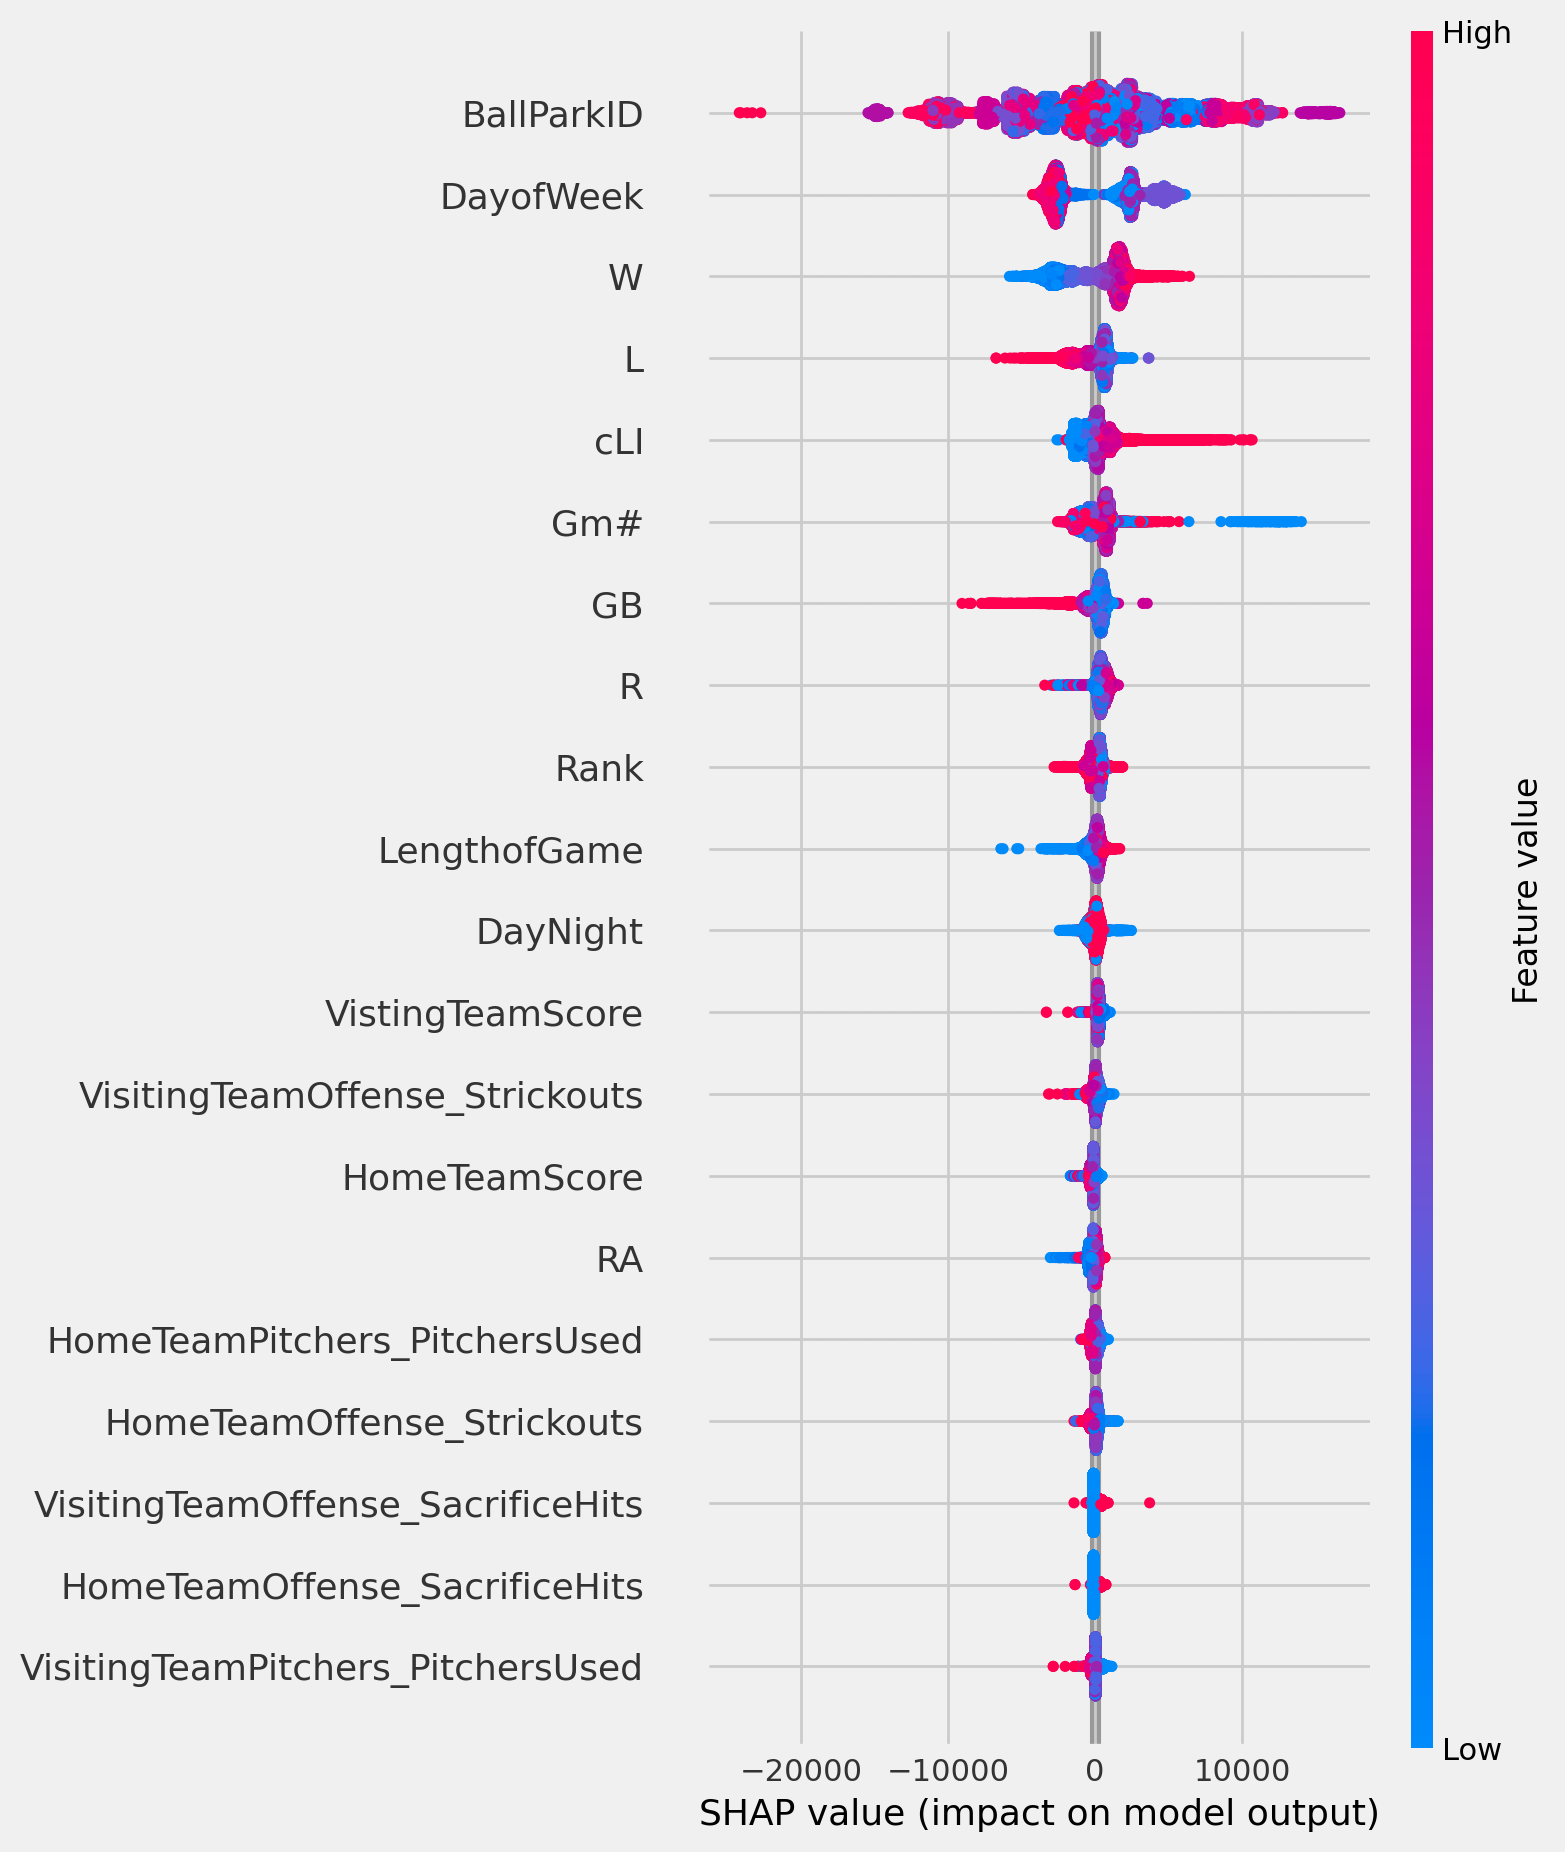

In [12]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [14]:
df.columns.tolist()

['Attendance',
 'Date',
 'Gm#',
 'R',
 'RA',
 'Rank',
 'GB',
 'Streak_count',
 'W',
 'L',
 'VistingTeamScore',
 'HomeTeamScore',
 'NumberofOuts',
 'LengthofGame',
 'cLI',
 'DayNight',
 'DayofWeek',
 'BallParkID',
 'VisitingTeamOffense_AtBats',
 'VisitingTeamOffense_Hits',
 'VisitingTeamOffense_Doubles',
 'VisitingTeamOffense_Triples',
 'VisitingTeamOffense_Homeruns',
 'VisitingTeamOffense_RBIs',
 'VisitingTeamOffense_SacrificeHits',
 'VisitingTeamOffense_SacrificeFlies',
 'VisitingTeamOffense_HitbyPitch',
 'VisitingTeamOffense_Walks',
 'VisitingTeamOffense_IntentionalWalks',
 'VisitingTeamOffense_Strickouts',
 'VisitingTeamOffense_StolenBases',
 'VisitingTeamOffense_CaughtStealing',
 'VisitingTeamOffense_GroundedintoDoublePlay',
 'VisitingTeamOffense_AwardedFirstonCatcherInterference',
 'VisitingTeamOffense_LeftOnBase',
 'VisitingTeamPitchers_PitchersUsed',
 'VisitingTeamPitchers_IndividualEarnedRuns',
 'VisitingTeamPitchers_TeamEarnedRuns',
 'VisitingTeamPitchers_WildPitches',
 'Visit